### Madipelli Rishitha
### Used Faster RCNN to train the data and predict for Mississipi Bridges

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2/detectron2'))
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [3]:
import os
os.chdir('/content/mydata')
os.listdir()

['.ipynb_checkpoints', 'output', 'train', 'val']

In [4]:
sys.path.insert(0, os.path.abspath('./detectron2'))

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
def get_dicts(img_dir,d):
    json_file = os.path.join(img_dir, "annotations.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns["images"]):
        record = {}
        filename = os.path.join(img_dir, v["file_name"])
        height, width = v["height"], v["width"]
        record["file_name"] =filename
        record["image_id"] = v["id"]
        record["height"] = height
        record["width"] = width
        annos = [anno for anno in imgs_anns["annotations"] if anno["image_id"] == v["id"]]
        objs = []
        for anno in annos:
            obj = {
                "bbox": anno["bbox"],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": anno["category_id"]-1,
                "iscrowd": anno.get("iscrowd", 0)
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
for d in ["train","val"]:
    DatasetCatalog.register("my_data_" + d, lambda d=d: get_dicts(f"{d}/",d))
    MetadataCatalog.get("my_data_" + d).set(thing_classes=["damaged"])

metadata = MetadataCatalog.get("my_data_train")

In [ ]:
# Configuration
import torch
assert torch.cuda.is_available(), "Make sure to enable GPU in Runtime > Change runtime type"

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_data_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 12
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR='/content/mydata/output'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/22 18:47:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[07/22 18:47:59 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/22 18:48:20 d2.utils.events]:  eta: 0:19:51  iter: 19  total_loss: 7.617  loss_cls: 0.6376  loss_box_reg: 0.02177  loss_rpn_cls: 5.574  loss_rpn_loc: 1.182    time: 0.9611  last_time: 1.3094  data_time: 0.3969  last_data_time: 0.5320   lr: 4.9953e-06  max_mem: 2406M
[07/22 18:48:40 d2.utils.events]:  eta: 0:18:34  iter: 39  total_loss: 4.129  loss_cls: 0.6292  loss_box_reg: 0.1532  loss_rpn_cls: 2.234  loss_rpn_loc: 1.059    time: 0.8629  last_time: 0.7281  data_time: 0.2699  last_data_time: 0.2284   lr: 9.9902e-06  max_mem: 2406M
[07/22 18:48:56 d2.utils.events]:  eta: 0:18:11  iter: 59  total_loss: 2.154  loss_cls: 0.6194  loss_box_reg: 0.2117  loss_rpn_cls: 0.3599  loss_rpn_loc: 0.8675    time: 0.8425  last_time: 0.7229  data_time: 0.2886  last_data_time: 0.2508   lr: 1.4985e-05  max_mem: 2406M
[07/22 18:49:16 d2.utils.events]:  eta: 0:18:17  iter: 79  total_loss: 1.877  loss_cls: 0.5679  loss_box_reg: 0.3113  loss_rpn_cls: 0.3336  loss_rpn_loc: 0.6575    time: 0.8890  last_time

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this mode
cfg.DATASETS.TEST = ("my_data_val", )
predictor = DefaultPredictor(cfg)

[07/22 19:10:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/mydata/output/model_final.pth ...


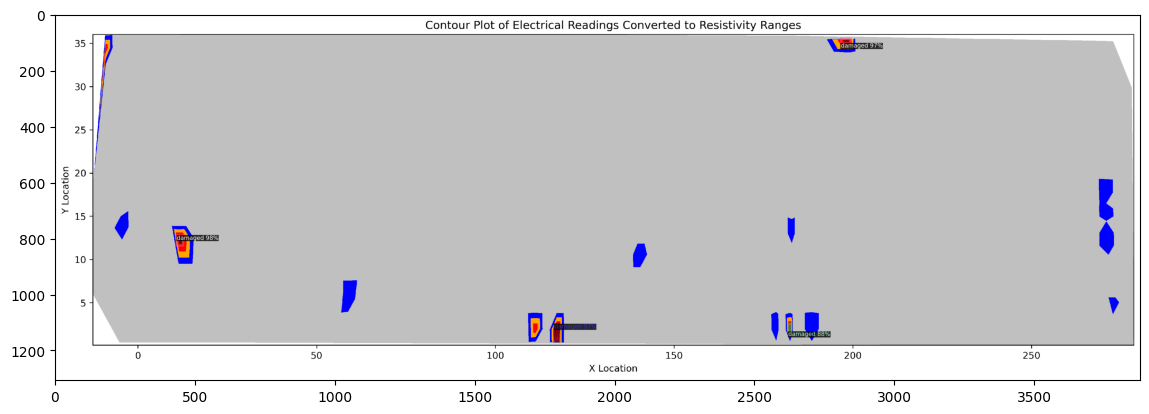

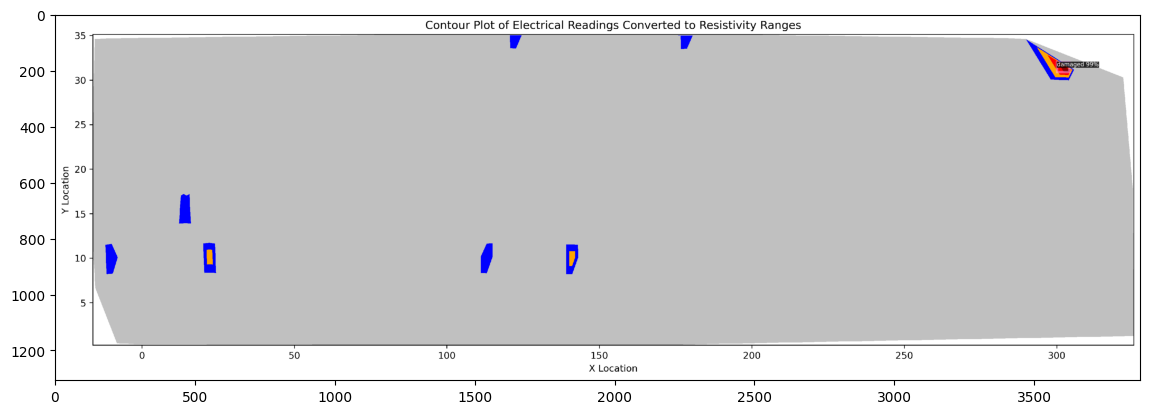

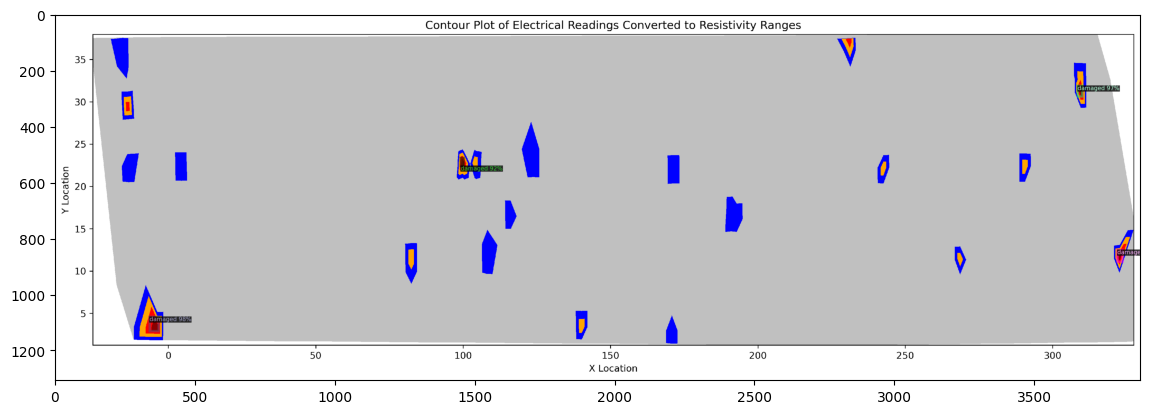

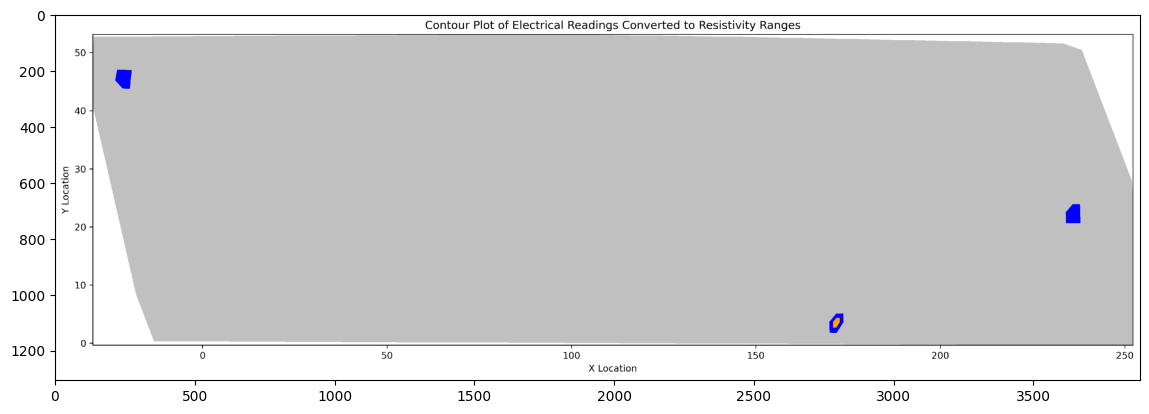

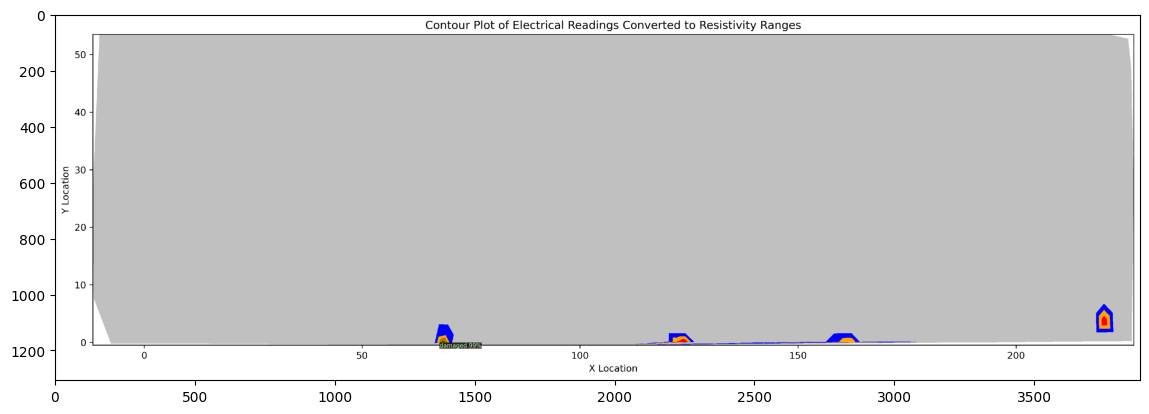

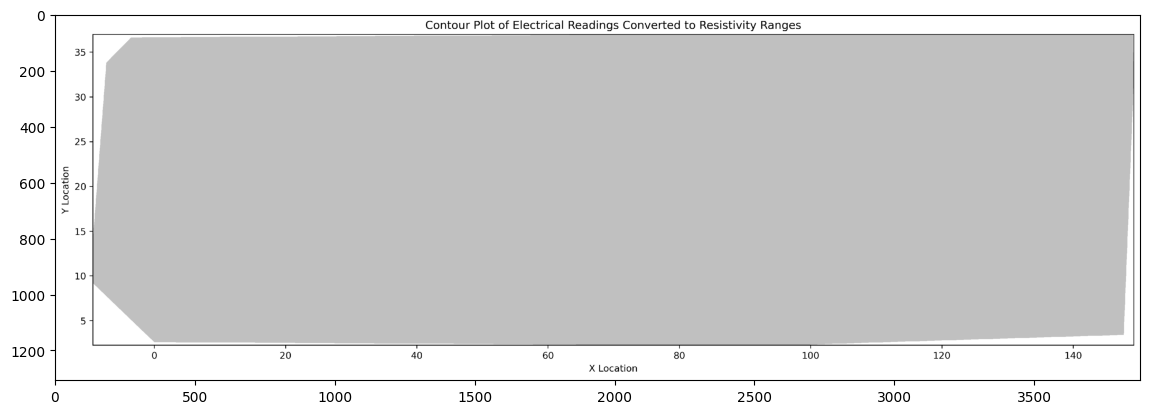

In [8]:
from detectron2.utils.visualizer import ColorMode
import random
import matplotlib.pyplot as plt
dataset_dicts = get_dicts("val/","val")
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

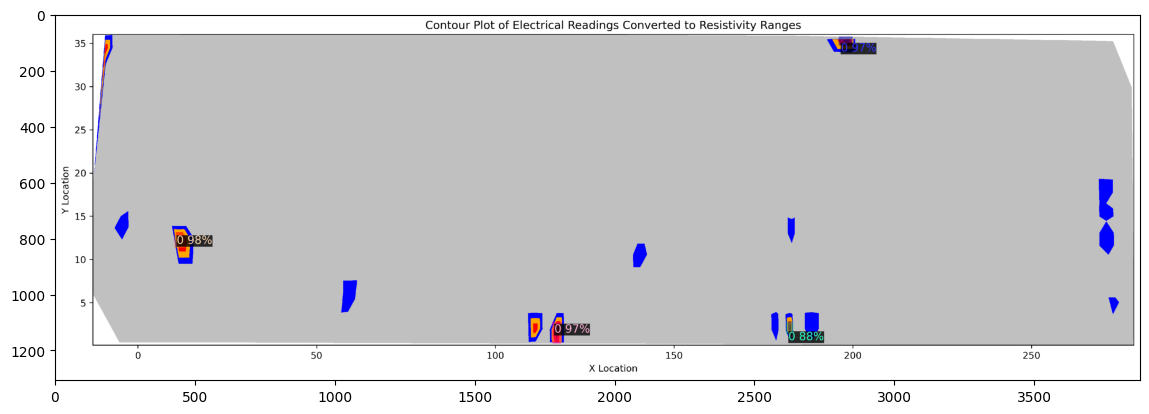

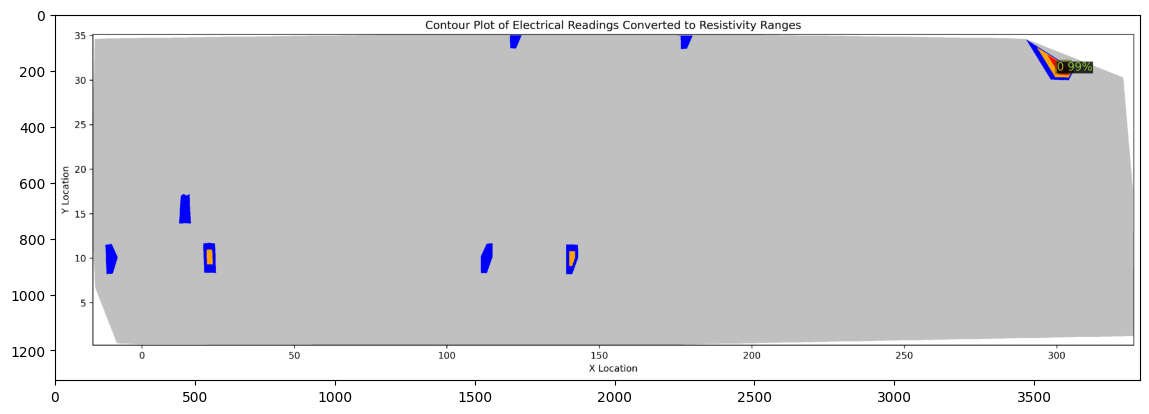

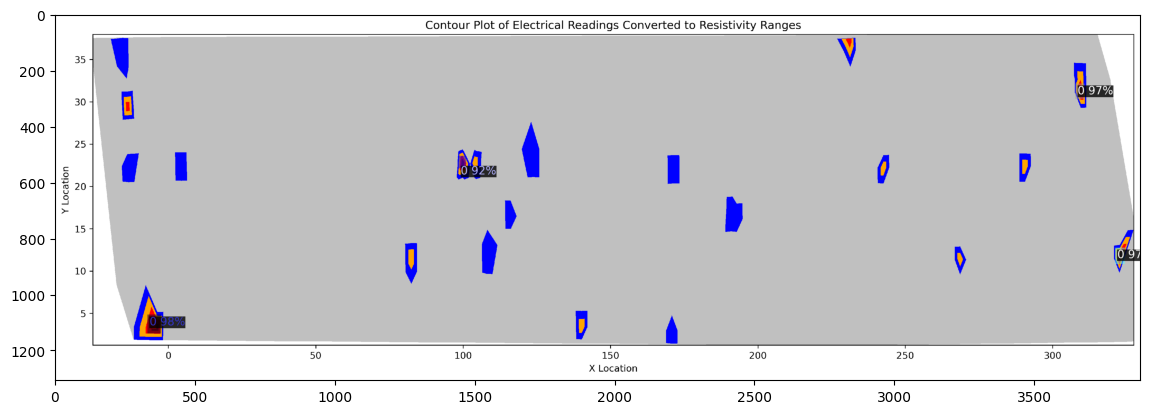

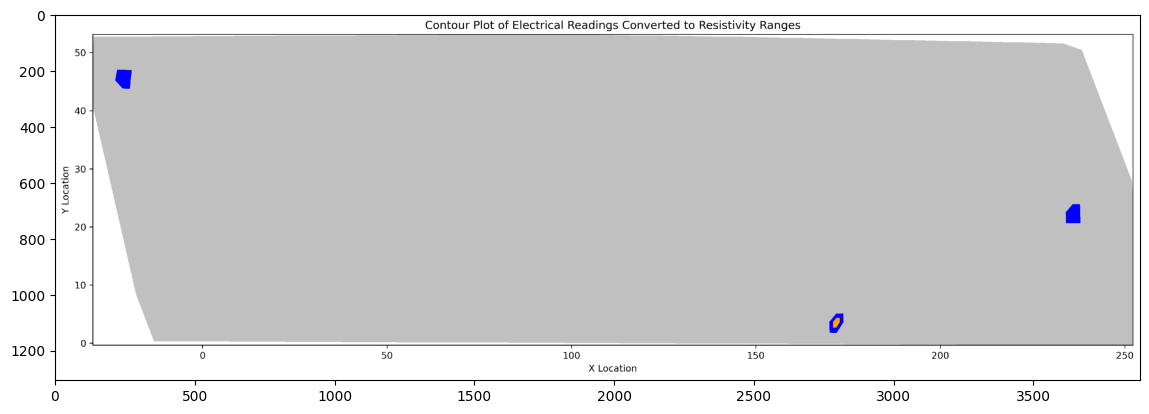

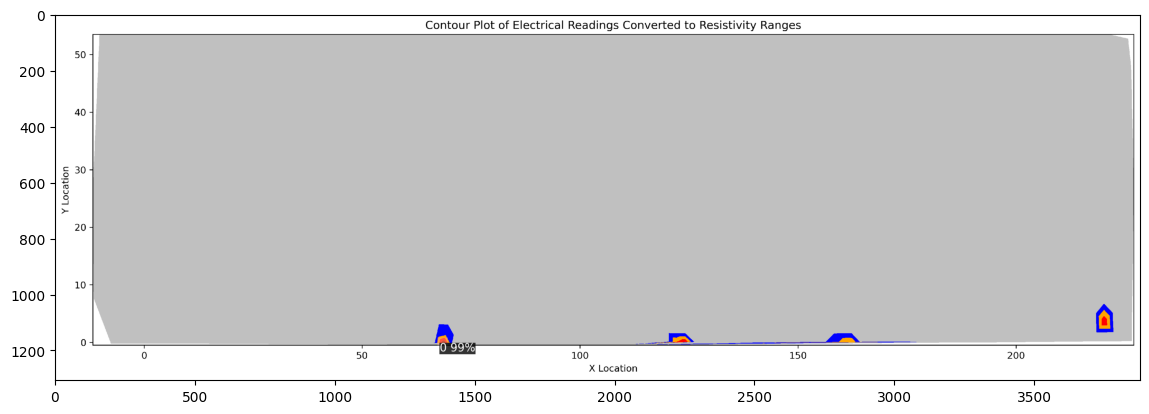

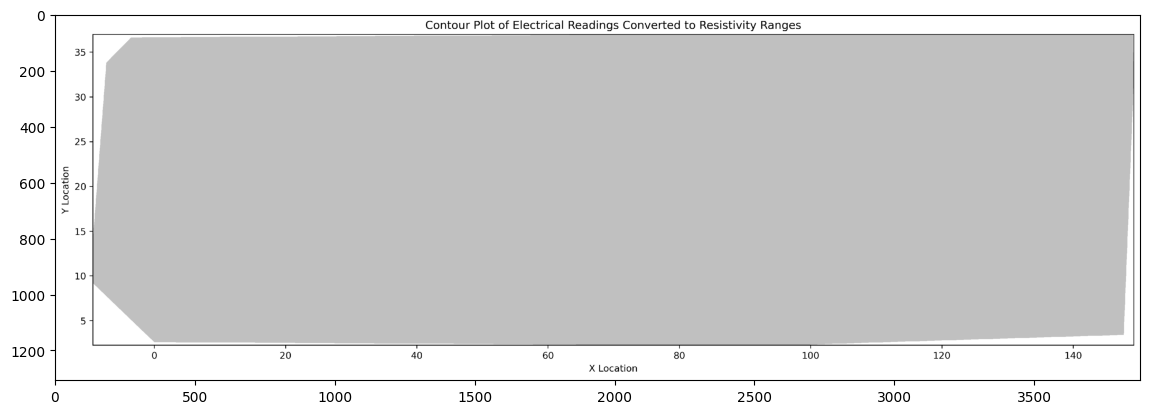

In [21]:
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
import cv2

class CustomVisualizer(Visualizer):
    def __init__(self, img_rgb, metadata=None, scale=1.0, instance_mode=ColorMode.IMAGE):
        super().__init__(img_rgb, metadata, scale, instance_mode)
        self._default_font_size = 60  # Set your desired font size here

# Your visualization loop
dataset_dicts = get_dicts("val/", "val")
metadata = MetadataCatalog.get("val")

for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = CustomVisualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()